## Calcolo dell'energia libera di Gibbs in funzione della temperatura e della pressione

L'esercitazione che segue utilizza un modulo python (*gibbs_tp.py*) che fa parte di una suite di programmi scritti per scopi professionali nell'ambito del modeling termodinamico dei sistemi geochimici e petrologici. Se ne illustreranno solo alcune caratteristiche e, precisamente, quelle utili ai fini di questa esercitazione.

La caratteristica principale del programma consiste nell'uso di una classe python (la classe *mineral*) per caricare da un database l'insieme completo delle proprietà termodinamiche di un certo numero di fasi minerali, insieme con tutte le funzioni necessarie per calcolarne l'energia libera o altre grandezze di interesse. 

Come vedremo, ogni fase minerale trattata è associata a una specifica istanza della classe.

Il codice che definisce la classe *mineral* è:

```
class mineral:
    def __init__(self,name,nick):
        self.name=name
        self.nick=nick
        self.eos='m'
        self.cp=None
        self.al=None
        self.k0=None
        self.kp=None
        self.dkt=None
        self.v0=None
        self.g0=None
        self.s0=None
        
    def info(self):
        print("Mineral: %s\n" % self.name)
        print("K0: %4.2f GPa, Kp: %4.2f, dK0/dT: %4.4f GPa/K, V0: %6.4f J/bar" \
              % (self.k0, self.kp, self.dkt, self.v0))
        print("G0: %8.2f J/mol, S0: %6.2f J/mol K\n" % (self.g0, self.s0))
        print("Cp coefficients and powers:")
        for ci in self.cp:
            print('{:>+8.4e}{:>+6.1f}'.format(ci[0],ci[1]))
        
        print("\nAlpha coefficients and powers:")
        for ai in self.al:
            print('{:>+8.4e}{:>+6.1f}'.format(ai[0],ai[1]))
            
    def load_ref(self,v0,g0,s0):
        self.v0=v0
        self.g0=g0
        self.s0=s0
         
    def load_bulk(self,k0, kp, dkt):
        self.k0=k0
        self.kp=kp
        self.dkt=dkt
        
    def load_cp(self,cpc,cpp):
        cl=list(zip(cpc,cpp))
        item=0
        self.cp=np.array([])
        for ic in cl:
            self.cp=np.append(self.cp,[cl[item][0], cl[item][1]])
            item=item+1
        self.cp=self.cp.reshape(item,2)
        
    def load_alpha(self, alc, alp):
        cl=list(zip(alc,alp))
        item=0
        self.al=np.array([])
        for ic in cl:
            self.al=np.append(self.al,[cl[item][0], cl[item][1]])
            item=item+1
        self.al=self.al.reshape(item,2) 
    
    def cp_t(self,tt):
        cpt=0.
        iterm=0
        for it in self.cp:
            cpt=cpt+self.cp[iterm,0]*(tt**self.cp[iterm,1])
            iterm=iterm+1
        return cpt 
    
    def alpha_t(self,tt):
        alt=0.
        iterm=0
        for it in self.al:
            alt=alt+self.al[iterm,0]*(tt**self.al[iterm,1])
            iterm=iterm+1
        return alt
    
    def kt(self,tt):
        return self.k0+(tt-298.15)*self.dkt
    
    def entropy(self,tt):
        fc=lambda ti: (self.cp_t(ti))/ti
        integ, err=scipy.integrate.quad(fc,298.15,tt)
        return integ+self.s0

    def volume_t(self,tt):
        fc= lambda ti: self.alpha_t(ti)
        integ,err=scipy.integrate.quad(fc,298.15,tt)
        return (self.v0)*np.exp(integ)
    
    def volume_p(self,tt,pp):
        k0t=self.kt(tt)
        vt=self.volume_t(tt)
        if self.eos=='m':
           fact=(1.-(pp*self.kp)/(pp*self.kp+k0t))**(1./self.kp)
           return fact*vt
        elif self.eos=='bm':
           pf=lambda f: (3*k0t*f*(1+2*f)**(5/2)*(1+3*f*(self.kp-4)/3)-pp)**2
           ff=scipy.optimize.minimize(pf,1,tol=0.00001)            
           return vt/((2*ff.x[0]+1)**(3/2))
    
    def volume_fix_t_p(self,tt):
        return lambda pp: self.volume_p(tt,pp) 
    
    def vdp(self,tt,pp):
        fv=self.volume_fix_t_p(tt)
        integ,err=scipy.integrate.quad(fv,0.0001, pp)
        return integ*1e4
    
    def g_t(self,tt):
        integ,err=scipy.integrate.quad(self.entropy, 298.15, tt)
        return integ
    
    def g_tp(self,tt,pp):
        return self.g0+self.vdp(tt,pp)-self.g_t(tt) 
    
    def alpha_p(self, tt, pp):
        v=self.volume_p(tt,pp)
        t_list=np.linspace(tt-10, tt+10, 5)
        vt_list=np.array([])
        for ti in t_list:
            vi=self.volume_p(ti,pp)
            vt_list=np.append(vt_list,vi)
        fitpv=np.polyfit(t_list,vt_list,2)
        fitder1=np.polyder(fitpv,1)
        altp=np.polyval(fitder1,tt)
        return 1*altp/v   
    
    def s_tp(self,tt,pp):
        gtp=lambda tf: self.g_tp(tf,pp)
        t_list=np.linspace(tt-5, tt+5, 5)
        g_list=np.array([])
        for ti in t_list:
            gi=self.g_tp(ti,pp)
            g_list=np.append(g_list,gi)
        fit=np.polyfit(t_list,g_list,2)
        fitder=np.polyder(fit,1)
        return -1*np.polyval(fitder,tt)
    
    def h_tp(self,tt,pp):
        g=self.g_tp(tt,pp)
        s=self.s_tp(tt,pp)
        return g+tt*s
```

Cerchiamo di interpretarlo nelle caratteristiche essenziali con qualche esempio.

Tanto per cominciare, lanciamo i due comandi che seguono per avere la grafica *inline* e caricare il programma

In [1]:
%matplotlib inline
%run gibbs_tp.py
import inspect as ins

La lista dei minerali che sono trattabili in questo sistema è contenuta nella variabile *name_list.mineral_names* che possiamo visualizzare scrivendo semplicemente:

In [2]:
name_list.mineral_names

['coe',
 'q',
 'fo',
 'fa',
 'foL',
 'faL',
 'ky',
 'sill',
 'andal',
 'per',
 'sp',
 'py',
 'ens',
 'cor']

Le sigle delle diverse fasi minerali sono conformi (con qualche eccezione) a quelle usate internazionalmente ('coe', coesite; 'q', quarzo; 'andal', andalusite; 'per', periclasio; 'sp', spinello, ecc...)

Come scrivevo sopra, ogni fase minerale è associata a una istanza della classe; per esempio:

```
py=mineral("pyrope","py")
```

crea una variabile *py* che contiene tutti i dati termodinamici del piropo e le funzioni che li utilizzano. Questi dati possono essere visualizzati con la funzione *py.info()*:

In [3]:
py.info()

Mineral: pyrope

K0: 173.70 GPa, Kp: 4.00, dK0/dT: -0.0261 GPa/K, V0: 11.3180 J/bar
G0: -5934105.00 J/mol, S0: 266.30 J/mol K

Cp coefficients and powers:
+6.3350e+02  +0.0
-5.1961e+06  -2.0
-4.3152e+03  -0.5

Alpha coefficients and powers:
+4.3600e-05  +0.0
-4.3600e-04  -0.5


Abbiamo quindi il bulk modulus $K_0$, il $K'$ (Kp), il $dK_0/dT$... e poi le espressioni che esprimono il calore specifico a pressione costante e l'espansione termica in funzione di $T$. Per esempio, per il piropo abbiamo un'equazione del tipo 

$$C_P(T)=633.5 - 5.1961\cdot 10^{6}T^{-2} - 4.3152\cdot 10^3T^{-0.5}$$

per il calore specifico (si noti che questa espressione non va bene per ottenere un $C_P$ valido per le temperature molto basse... perchè?); volendo sapere il $C_P$ del piropo a *T=500 K* non dovremo far altro che usare una delle funzioni (*metodi*) della classe e, precisamente, *cp_t* che accetta, come argomento, la temperatura a cui si voglia fare il calcolo.

Il codice della funzione (*metodo* della classe *mineral* di cui la variabile *py* è una istanza) è:

In [4]:
print(ins.getsource(mineral.cp_t))

    def cp_t(self,tt):
        cpt=0.
        iterm=0
        for it in self.cp:
            cpt=cpt+self.cp[iterm,0]*(tt**self.cp[iterm,1])
            iterm=iterm+1
        return cpt 



Il nucleo centrale della funzione consiste di un ciclo (*for*) in cui vengono sommati tutti i termini della espansione del $C_P$ in serie di potenze del di $T$. I coefficienti di questa espansione sono conservati nella prima colonna (di indice 0) dell'array *cp* (*self.cp*); gli esponenti sono invece nella seconda colonna (di indice 1) dello stesso array.  

In [5]:
py.cp_t(500).round(2)

419.73

*py.cp_t(T)* calcola il $C_P$ alla temperatura $T$; il *round(2)* postfisso ha solo un effetto *cosmetico* limitando a 2 il numero di cifre decimali. Il dato è calcolato in J/mole K. 

Possiamo anche mettere in grafico i valori del $C_P$ in un dato intervallo di temperature, scrivendo il semplice codice che segue:

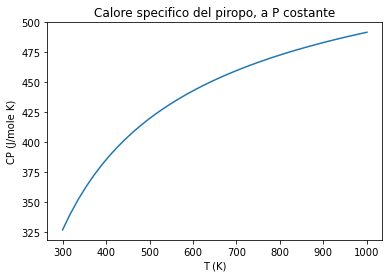

In [6]:
t_list=np.linspace(300,1000,40)   # lista di 40 valori di temperatura tra 300 e 1000 K
cp_list=py.cp_t(t_list)           # lista dei corrispondenti valori di CP

plt.figure()
plt.plot(t_list,cp_list)
plt.xlabel("T (K)")
plt.ylabel("CP (J/mole K)")
plt.title("Calore specifico del piropo, a P costante")
plt.show()

Volendo il $C_P$, che so, della *coesite* alla stessa temperatura, basterà richiedere:

In [7]:
coe.cp_t(500).round(2)

58.74

Per quanto riguarda il piropo, il suo volume molare è conservato in py.v0:

In [8]:
py.v0

11.318

Il suo valore è dato in J/bar... unità di misura abbastanza *strana* per un volume! A cosa corrisponde? Vediamo:

<br>
1 J = 1 N m; 1 bar 10^5 Pa = 10^5 N/m^2, da cui 1 J/bar = 10^-5 N m m^2/N = 10^-5 m^3 = 10 cm^3 

Quindi il volume molare del piropo è 113.18 cm^3. Ma perchè si usa un'unità di misura così inusuale?
<br> Perchè nel modeling termodinamico tutto viene definito a partire dall'energia libera di Gibbs, e 

$$V=\left(\frac{\partial G}{\partial P}\right)_T$$

Poichè $G$ è dato in J (è un'energia) e la pressione è data in bar, allora $V$ è dato in J/bar. 

Siamo *curiosi* adesso di sapere quale sia il volume molare del piropo a *T*=500 K, e *P*=5 GPa (notare che la pressione viene qui data in GPa e non in bar): usiamo la funzione *volume_p(T,P)*:

In [9]:
py.volume_p(500,5).round(3)

11.053

che utilizza i dati dell'espansione termica e dell'equazione di stato (con il bulk modulus e la sua dipendenza dalla temperatura) per fare il calcolo:

In [10]:
print(ins.getsource(mineral.volume_p))

    def volume_p(self,tt,pp):
        k0t=self.kt(tt)
        vt=self.volume_t(tt)
        if self.eos=='m':
           fact=(1.-(pp*self.kp)/(pp*self.kp+k0t))**(1./self.kp)
           return fact*vt
        elif self.eos=='bm':
           pf=lambda f: (3*k0t*f*(1+2*f)**(5/2)*(1+3*f*(self.kp-4)/3)-pp)**2
           ff=scipy.optimize.minimize(pf,1,tol=0.00001)            
           return vt/((2*ff.x[0]+1)**(3/2))



La funzione si calcola preventivamente il bulk modulus alla temperatura specificata in input (*tt*) usando la funzione *self.kt*; si calcola anche il volume di equilibrio alla temperatura *tt* e pressione *zero* (usando l'espansione termica del minerale) tramite la funzione *self.volume_t*.

In seconda battuta, distinguendo tra una equazione di stato di tipo *Murnaghan* (*self.eos='m'*) e una *Birch-Murnaghan* (*self.eos='bm'*), viene calcolato il volume alla pressione specificata in input (*pp*). Nel caso di una EoS di tipo Murnaghan, il calcolo del volume è *analitico* (l'equazione *P(V)* viene invertita in una *V(P)*); nel caso di una EoS di tipo Birch-Murnaghan, il calcolo analitico non è possibile (data la forma dell'equazione) e viene perciò seguita una via *numerica* tramite la funzione *minimize*  della libreria *scipy.optimize*. 

La funzione *g_tp(T,P)* calcola l'energia libera $G$ in date condizioni $T$, $P$. Questa funzione fa uso di altre due funzioni *self.vdp* che calcola il contributo 

$$\int_{0}^{P}V(P,T)dP$$ 

a $T$ costante, e la funzione *self.g_t* che calcola il contributo proveniente dall'integrazione $-SdT$ (a $P$ costante). Entrambe queste funzioni calcolano gli integrali coinvolti usando la funzione *quad* della libreria *scipy.integrate*.

In [11]:
print(ins.getsource(mineral.g_tp))

    def g_tp(self,tt,pp):
        return self.g0+self.vdp(tt,pp)-self.g_t(tt) 



In [12]:
print(ins.getsource(mineral.vdp))

    def vdp(self,tt,pp):
        fv=self.volume_fix_t_p(tt)
        integ,err=scipy.integrate.quad(fv,0.0001, pp)
        return integ*1e4



In [13]:
print(ins.getsource(mineral.g_t))

    def g_t(self,tt):
        integ,err=scipy.integrate.quad(self.entropy, 298.15, tt)
        return integ



Calcoliamo dunque l'energia libera $G$ del piropo a 500 K e 5 GPa:

In [14]:
print('{:.4e}'.format(py.g_tp(500,5)))

-5.4481e+06


OK, d'accordo, l'istruzione sopra sempra *arabo*, ma in realtà è solo un modo per ottenere un numero scritto con notazione scientifica con quattro cifre decimali. Per esempio, se la variabile che vogliamo scrivere fosse:

In [15]:
a=2564.566791

e la volessimo rappresentata con sole 3 cifre decimali, scriveremo un comando di *print* con incorporate le istruzioni per la *formattazione*: {:.3e}, che scriveranno la variabile in notazione scientifica (*e*): 

In [16]:
print('{:.3e}'.format(a))

2.565e+03


La funzione *plot_g_t* esegue il plot dell'energia libera a *npoint* valori di temperatura, un dato range *tmin, tmax*, a una pressione fissata *P*. Per esempio, a 3GPa: 

```
plot_g_t(300, 700, 12, 3)
```

con *tmin*=300 K; *tmax*=700 K, *npoint*=12, *P*=3 GPa

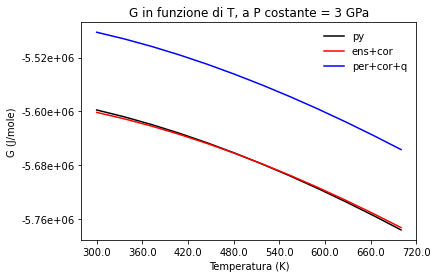

In [17]:
plot_g_t(300,700,12,3)

All'interno della funzione sono già specificate le fasi su cui si vuole fare il calcolo. Qui abbiamo 3 curve:

 - piropo: Mg3Al2Si3O12  (curva in nero)
 - enstatite + corindone: 3/2 Mg2Si2O6 + Al2O3   (curva in rosso)
 - periclasio + corindone + quarzo: 3 MgO + Al2O3 + 3 SiO2   (curva in blu)
 
Vediamo che (a 3 GPa) l'insieme *per+cor+q* non è mai stabile rispetto ad altre fasi (la sua energia libera è sempre la più alta a qualunque *T*, il che è vero anche a pressioni più alte). Enstatite + corindone (ens+cor) è più stabile rispetto al piropo a bassa temperatura, mentre ad alta T è più stabile il piropo (la T di transizione è intorno ai 500 K).

Abbiamo una funzione analoga per fare un calcolo di $G$ in funzione della pressione, a temperatura fissata *T*: *plot_g_p(pmin,pmax,npoint,T)*; qui abbiamo Pmin=0, Pmax=10 GPa (12 punti), T=500 K:

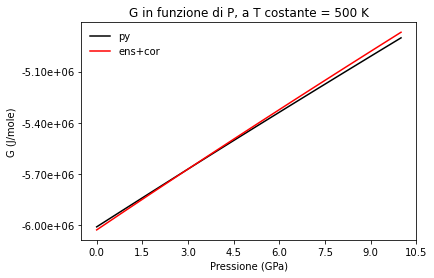

In [18]:
plot_g_p(0,10,12,500)

E' molto semplice modificare queste funzioni di plot per considerare fasi minerali diverse. Per esempio, *plot_g_t* è riscritta nella cella seguente (cella che può essere *eseguita*, caricando la nuova funzione in luogo della precedente). Per esempio, vogliamo considerare l'equilibrio cianite (*ky*), andalusite (*andal*):

In [19]:
def plot_g_t(tmin,tmax,npoint,pres,ret=False):
    t_list=np.linspace(tmin,tmax,npoint)
      
    g_1=np.array([])
    g_2=np.array([])
    for it in t_list:
        ig=ky.g_tp(it,pres)        # specificare qui la cianite:   ky.g_tp 
        ig2=andal.g_tp(it,pres)    # specificare qui l'andalusite: andal.g_tp
        g_1=np.append(g_1,ig)
        g_2=np.append(g_2,ig2)
        
    fig=plt.figure()
    ax=fig.add_subplot(111) 
    ax.title.set_text("G in funzione di T, a P costante = "+str(pres)+" GPa")
    ax.plot(t_list,g_1,"k-",label="ky")                     # cambiare la label
    ax.plot(t_list,g_2,"r-",label="andal")                  # cambiare la label
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%4.2e'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.set_xlabel("Temperatura (K)")
    ax.set_ylabel("G (J/mole)")
    ax.legend(frameon=False)
    plt.show()
    
    if ret:
        return t_list, g_1, g_2   # variabili in uscita se ret=True

... e chiamare la funzione con gli argomenti desiderati:

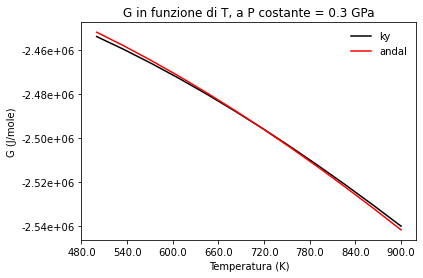

In [20]:
plot_g_t(500,900,12,0.3)

Vogliamo adesso determinare la temperatura *precisa* a cui abbiamo la transizione da cianite ad andalusite per una pressione di 0.2 GPa. Richiamiamo la funzione plot_g_t specificando l'argomento opzionale *ret=True*: La funzione restituisce in tal caso, le liste dei valori di temperatura, e le corrispondenti liste delle energie libere di cianite e andalusite 

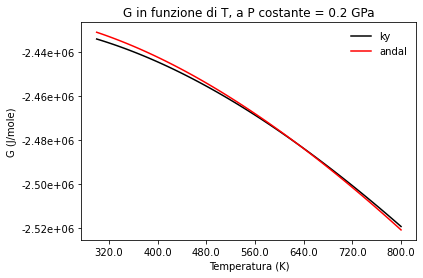

In [21]:
t, g_ky, g_andal=plot_g_t(300,800,100,0.2,ret=True)

Calcoliamo adesso, temperatura per temperatura, la funzione $dg = (G_{ky}-G_{andal})^2$ e cerchiamone il minimo; il minimo (*idealmente* 0) è dove le energie libere delle due fasi sono uguali e rappresenta dunque la pressione di equilibrio:

In [27]:
dg=(g_ky-g_andal)**2

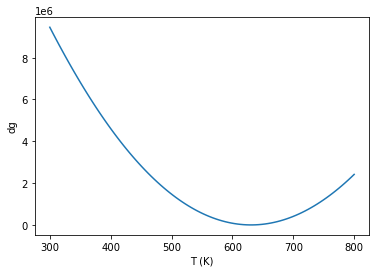

In [28]:
plt.figure()
plt.plot(t,dg)
plt.xlabel("T (K)")
plt.ylabel("dg")
plt.show()

La <i>posizione nella lista dg a cui la stessa dg è minima</i> è estratta dalla funzione *argmin* di numpy. Questa posizione viene qui salvata nella variabile *pos* per un utilizzo successivo.

In [30]:
pos=np.argmin(dg)
print(pos)

65


Enfatizzo che questo numero {{ pos }} non è il valore minimo di dg, ma è la *posizione* nella lista alla quale è presente quel valore. Il valore minimo di dg si ottiene invece con la funzione *min*:

In [31]:
min(dg).round(2)

470.92

Non è esattamente 0, a causa della risoluzione con cui abbiamo costruito la lista del valori di temperatura (200 punti in un intervallo di 500 K)

Andiamo a vedere il corrispondente valore di temperatura nella posizione {{ pos }} della lista delle temperature:

In [33]:
t[pos].round(1)

628.3

Se vogliamo fare una ricerca più accurata con un metodo più sofisticato, conoscendo la posizione approssimata del minimo in *T*, costruiamo le liste *t* e *dg* nei dintorni del minimo, poi interpoliamo i risultati con una funzione 

$$dg = at^2 + bt + c$$

usando la funzione *polyfit* di numpy. Calcoliamo poi la posizione del minimo uguagliando a 0 la derivata analitica della funzione *dg(t)* interpolata: $t_{min}=-b/2a$

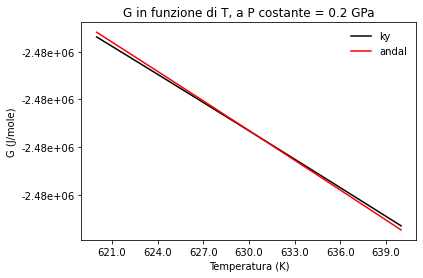

Temperatura di transizione: 630.63 K
Minimo di dg: -0.31


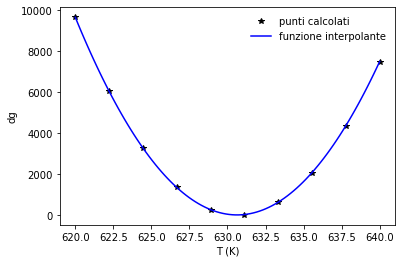

In [35]:
tmin=620
tmax=640
t, g_ky, g_andal=plot_g_t(tmin,tmax,10,0.2,ret=True)
dg=(g_ky-g_andal)**2
reg=np.polyfit(t,dg,2)
tt=-1*reg[1]/(2*reg[0])
print("Temperatura di transizione: %5.2f K" % tt)

# Notare l'uso della funzione polyval che accetta i parametri
# a, b e c (conservati in reg e determinati da polyfit)
# insieme a un valore di t, per restituire il valore del
# polinomio appunto al valore di t
print("Minimo di dg: %3.2f" % np.polyval(reg,tt))  

# Parte grafica (opzionale)
new_tlist=np.linspace(tmin,tmax,100)
new_dg=np.polyval(reg,new_tlist)
plt.figure()
plt.plot(t,dg,"k*",label="punti calcolati")
plt.plot(new_tlist,new_dg,"b-",label="funzione interpolante")
plt.legend(frameon=False)
plt.xlabel("T (K)")
plt.ylabel("dg")
plt.show()



Questa è la temperatura a cui si ha l'equilibrio cianite/andalusite a una pressione di 0.2 GPa; a T più bassa è stabile la cianite; a T più alta è stabile l'andalusite.

Facciamo lo stesso giochetto con l'equilibrio quarzo/coesite, alla temperatura di 300 K. Modifichiamo la funzione *plot_g_p*

In [36]:
def plot_g_p(pmin,pmax,npoint,temp,ret=False):
    p_list=np.linspace(pmin,pmax,npoint)
      
    g_1=np.array([])
    g_2=np.array([])
    for ip in p_list:
        ig=coe.g_tp(temp,ip)           # specifichiamo qui la coesite
        ig2=q.g_tp(temp,ip)            # specifichiamo qui il quarzo
        g_1=np.append(g_1,ig)
        g_2=np.append(g_2,ig2)
        
    fig=plt.figure()
    ax=fig.add_subplot(111) 
    ax.title.set_text("G in funzione di P, a T costante = "+str(temp)+" K")
    ax.plot(p_list,g_1,"k-",label="coe")                  # cambiamo l'etichetta
    ax.plot(p_list,g_2,"r-",label="q")                    # cambiamo l'etichetta
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%4.2e'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.set_xlabel("Pressione (GPa)")
    ax.set_ylabel("G (J/mole)")
    ax.legend(frameon=False)
    plt.show()  
    
    if ret:
         return p_list, g_1, g_2

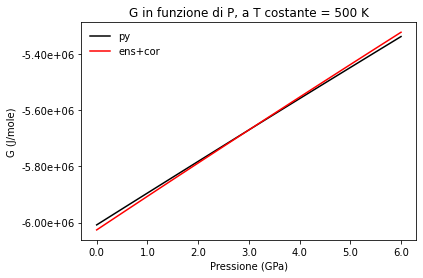

In [5]:
plot_g_p(0, 6, 12, 500)

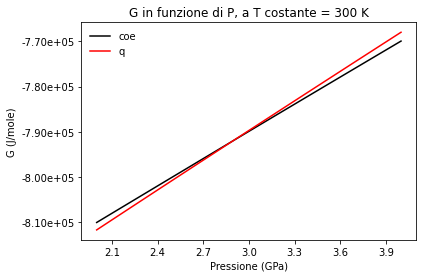

In [41]:
p, gq, gc=plot_g_p(2,4,50,300,ret=True)

In [42]:
dg=(gq-gc)**2
print("Pressione di transizione: %3.2f GPa" % p[np.argmin(dg)])

Pressione di transizione: 2.90 GPa


Abbiamo poi una funzione più *evoluta* che calcola la pressione di equilibrio tra diverse fasi minerali, in un dato intervallo di temperatura. Si tratta della funzione *equilib* che ha come argomenti:

```
equilib(Tmin, Tmax, npoint, prod, rea)
```

*prod* e *rea* sono liste di prodotti e reagenti con i rispettivi coefficienti stechiometrici. Per esempio, per la reazione <br>

3/2 enstatite + 1 corindone <---> 1 piropo <br>

diamo prod=\['py',1\] e rea=\['ens', 1.5, 'cor',1\]


  T (K)  P (GPa)  DH(J/mol)  DS (J/mol K)  DV (J/bar)  Slope (bar/K)
  300.0   3.67     5304.500     17.682       -0.527       -33.54    
  363.6   3.46     6480.825     17.822       -0.534       -33.37    
  427.3   3.25     7656.223     17.919       -0.541       -33.10    
  490.9   3.04     8767.402     17.860       -0.549       -32.53    
  554.5   2.83     9783.931     17.643       -0.557       -31.69    
  618.2   2.64    10691.080     17.294       -0.565       -30.62    
  681.8   2.44    11482.234     16.841       -0.573       -29.40    
  745.5   2.26    12155.205     16.306       -0.581       -28.07    
  809.1   2.09    12710.304     15.709       -0.589       -26.67    
  872.7   1.92    13149.277     15.067       -0.597       -25.23    
  936.4   1.77    13474.697     14.390       -0.605       -23.78    
 1000.0   1.62    13689.600     13.690       -0.613       -22.33    




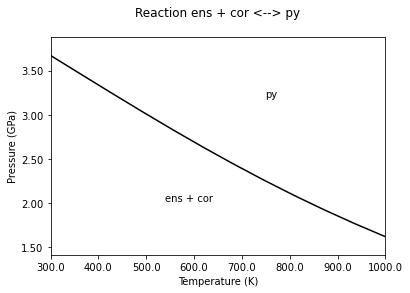


Average Clapeyron Slope (from Delta S/Delta V): -29.19 bar/K
Clapeyron slope (from a linear fit of the P/T curve): -29.53 bar/K


In [43]:
equilib(300,1000,12,prod=['py',1], rea=['ens',1.5,'cor',1])

L'aspetto della funzione *equilib* appare forse un po' complicato... ma in realtà le complicazioni sono solo dovute al fatto che questa deve essere in grado di selezionarsi *da sola* i dati termodinamici delle diverse fasi specificate in input e di tenere conto, in modo automatico, dei coefficienti stechiometrici della reazione esaminata: 

In [44]:
print(ins.getsource(equilib))

def equilib(tini,tfin,npoint,pini=1,prod=['py',1], rea=['ens',1.5,'cor', 1]):
    """
    Computes the equilibrium pressure for a reaction involving a
    given set of minerals, in a range of temperatures.
    
    Args:
        tini: minimum temperature in the range
        tfin: maximum temperature in the range
        npoint: number of points in the T range
        pini (optional): initial guess for the pressure
        prod: list of products of the reaction in the form 
              [name_1, c_name_1, name_2, c_name_2, ...]
              where name_i is the name of the i^th mineral, as stored
              in the database, and c_name_i is the corresponding
              stoichiometric coefficient
        rea:  list of reactants; same syntax as the "prod" list.
        
    Example:
        equilib(300, 500, 12, prod=['py',1], rea=['ens', 1.5, 'cor', 1])
    """
    
    lprod=len(prod)
    lrea=len(rea)
    prod_spec=prod[0:lprod:2]
    prod_coef=prod[1:lprod:2]
    rea_spec=rea[0

E' noto che lo spinello $\rm{MgAl_2O_4}$, in alta pressione, si decompone in periclasio (MgO) + corindone (Al2O3). Vogliamo indagare quale sia il campo P/T a cui avviene la reazione. Cominciamo con l'esplorare gli andamenti dell'energia libera delle fasi coinvolte. In particolare, modifichiamo la funzione plot_g_p ponendo nelle due variabili *g_1* e *g_2* in modo che:

$g_1=G_{sp}$ <br>
$g_2=G_{cor}+G_{per}$

In [45]:
def plot_g_p(pmin,pmax,npoint,temp,ret=False):
    p_list=np.linspace(pmin,pmax,npoint)
      
    g_1=np.array([])
    g_2=np.array([])
    for ip in p_list:
        ig=sp.g_tp(temp,ip)                       # spinello
        ig2=cor.g_tp(temp,ip)+per.g_tp(temp,ip)   # corindone + periclasio         
        g_1=np.append(g_1,ig)
        g_2=np.append(g_2,ig2)
        
    fig=plt.figure()
    ax=fig.add_subplot(111) 
    ax.title.set_text("G in funzione di P, a T costante = "+str(temp)+" K")
    ax.plot(p_list,g_1,"k-",label="sp")                 
    ax.plot(p_list,g_2,"r-",label="per+cor")
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%4.2e'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.set_xlabel("Pressione (GPa)")
    ax.set_ylabel("G (J/mole)")
    ax.legend(frameon=False)
    plt.show()  
    
    if ret:
         return p_list, g_1, g_2

Vediamo quindi l'andamento delle energie libere (tra 10 e 22 GPa, in 12 punti, a T=1700 K)

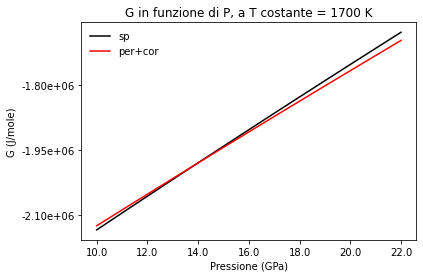

In [46]:
plot_g_p(10,22,12,1700)

Quindi usiamo *equilib* tra T=1500 K e 2000 K (in 12 punti): 


  T (K)  P (GPa)  DH(J/mol)  DS (J/mol K)  DV (J/bar)  Slope (bar/K)
 1500.0   12.86  -18043.761    -12.029       -0.247        48.73    
 1545.5   13.09  -18840.691    -12.191       -0.246        49.61    
 1590.9   13.31  -19636.057    -12.343       -0.245        50.46    
 1636.4   13.55  -20429.066    -12.484       -0.244        51.28    
 1681.8   13.78  -21218.984    -12.617       -0.242        52.07    
 1727.3   14.02  -22005.123    -12.740       -0.241        52.84    
 1772.7   14.26  -22786.844    -12.854       -0.240        53.59    
 1818.2   14.51  -23563.554    -12.960       -0.239        54.30    
 1863.6   14.75  -24334.703    -13.058       -0.237        55.00    
 1909.1   15.01  -25099.781    -13.148       -0.236        55.67    
 1954.5   15.26  -25858.318    -13.230       -0.235        56.33    
 2000.0   15.52  -26609.880    -13.305       -0.234        56.96    




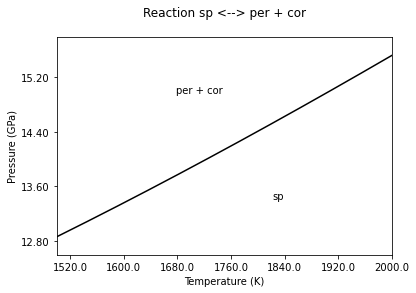


Average Clapeyron Slope (from Delta S/Delta V):  53.07 bar/K
Clapeyron slope (from a linear fit of the P/T curve):  53.13 bar/K


In [47]:
equilib(1500,2000,12,prod=['per',1,'cor',1], rea=['sp',1])

Il risultato è in sostanziale accordo con le osservazioni sperimentali.